# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [44]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.modules.game import Game
from src.helpers.create_q_dict import init_q
from src.helpers.runner import play_n_games, play_round, select_action
from src.helpers.evaluation import cummulative_rewards_per_round, play_games_bankrolls, assess_static_outcomes
from src.modules.train import Trainer
from src.helpers.plotting import plot_loss, plot_correctness, plot_mesh, plot_bar, generate_grid, generate_mesh
from src.helpers.q_learning import gen_episode


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it"s equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [8]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}


### I'll learn according to standard rules of play. I can evaluate by tweaking rules to observe house edge for both.

In [9]:
n_rounds_evaluate = 50
n_games_evaluate = 200

n_episodes = 3_500_000
gamma = .95
lr = .001
every = 50_000
method = "thompson" # "thompson" or "epsilon"


n_players = 1 # number of players
wagers = [1]*n_players # wagers per player "units"

eps_min = .1
eps_decay = np.log(1 / eps_min) / (n_episodes*.75)

trainer = Trainer(
    early_stop=False,
    method=method,
    lr=lr,
    gamma=gamma,
    eps_decay=eps_decay,
    eps_min=eps_min,
    leniency=20,
    moves_blacklist=["surrender"]
)

game = Game(**game_hyperparams)

eps = None
for r in range(n_episodes):
    if method == "epsilon":
        eps = max(eps_min, np.exp(-eps_decay * r))
    trainer.step(
        game=game,
        wagers=wagers,
        eps=eps,
        reset_deck=True # I elect to reset the deck each time, since I don't care for card count here. Just assume hands are purely random.
    )
    if not r % every:
        reward, correctness = await trainer.evaluate(
            n_rounds=n_rounds_evaluate,
            n_games=n_games_evaluate,
            game_hyperparams=game_hyperparams
        )

        print(f"{r+1} of {n_episodes} -- Score : {reward:.6f} -- % Correct : {correctness:.6f} -- EPS : {eps or -1:.6f}")

        if trainer.stop:
            print("early stopping")
            break

Qlearned = trainer.get_q(backtrack=False)

1 of 3500000 -- Score : -0.450550 -- % Correct : 0.459016 -- EPS : -1.000000
50001 of 3500000 -- Score : -0.043950 -- % Correct : 0.783784 -- EPS : -1.000000
100001 of 3500000 -- Score : -0.024200 -- % Correct : 0.707692 -- EPS : -1.000000
150001 of 3500000 -- Score : -0.027050 -- % Correct : 0.852941 -- EPS : -1.000000
200001 of 3500000 -- Score : -0.017750 -- % Correct : 0.847458 -- EPS : -1.000000
250001 of 3500000 -- Score : -0.015800 -- % Correct : 0.886076 -- EPS : -1.000000
300001 of 3500000 -- Score : -0.028100 -- % Correct : 0.921875 -- EPS : -1.000000
350001 of 3500000 -- Score : 0.018350 -- % Correct : 0.919355 -- EPS : -1.000000
400001 of 3500000 -- Score : -0.019650 -- % Correct : 0.929577 -- EPS : -1.000000
450001 of 3500000 -- Score : -0.018400 -- % Correct : 0.921053 -- EPS : -1.000000
500001 of 3500000 -- Score : -0.025600 -- % Correct : 0.904110 -- EPS : -1.000000
550001 of 3500000 -- Score : -0.020650 -- % Correct : 0.935484 -- EPS : -1.000000
600001 of 3500000 -- Sc

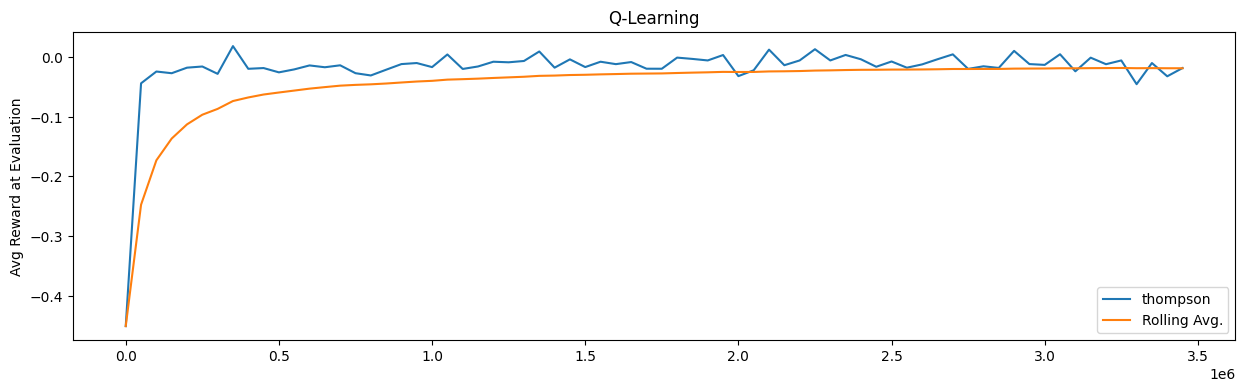

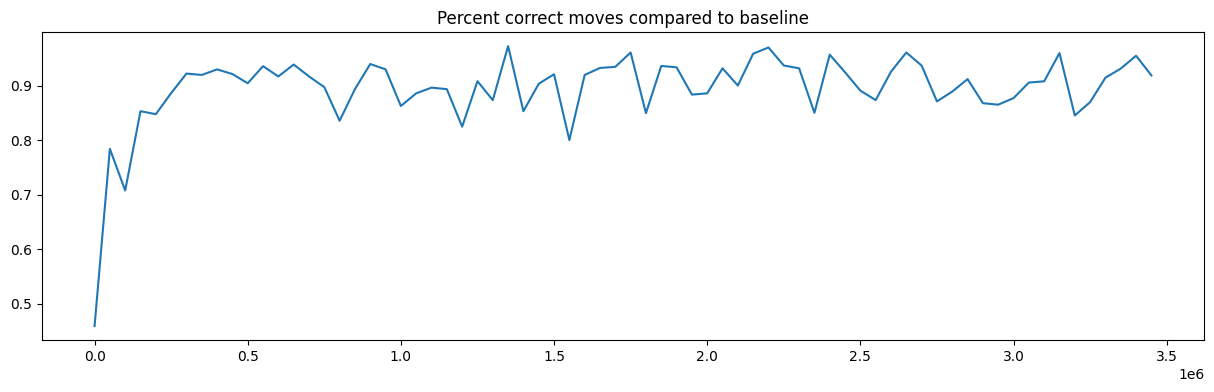

In [10]:
plot_loss(array=trainer.eval, every=every, label=method, include_max=False)

plot_correctness(array=trainer.correctness, every=every)

In [11]:
np.save("./models/Q", Qlearned)

In [12]:
Qlearned = np.load("./models/Q.npy",allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [13]:
n_games = 2_500
n_rounds = 50

print("Generating Random Rewards...")
randQ = init_q()
rewards = await play_n_games(
    q=randQ,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
random_rewards = cummulative_rewards_per_round(rewards)[:, 0]

print("Generating Learned Rewards...")
rewards = await play_n_games(
    q=Qlearned,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
learned_rewards = cummulative_rewards_per_round(rewards)[:, 0]
    
print("Generating Accepted Rewards... (found online to be optimal play)")
accepted_q = init_q(mode="accepted")
rewards = await play_n_games(
    q=accepted_q,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
accepted_rewards = cummulative_rewards_per_round(rewards)[:, 0]
    
print("Generating Meh Rewards...")
somewhat_smart_q = init_q(mode="house")
rewards = await play_n_games(
    q=somewhat_smart_q,
    wagers=[1],
    n_rounds=50,
    n_games=2_500,
    game_hyperparams=game_hyperparams
)
meh_rewards = cummulative_rewards_per_round(rewards)[:, 0]
print("Done")

Generating Random Rewards...
Generating Learned Rewards...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


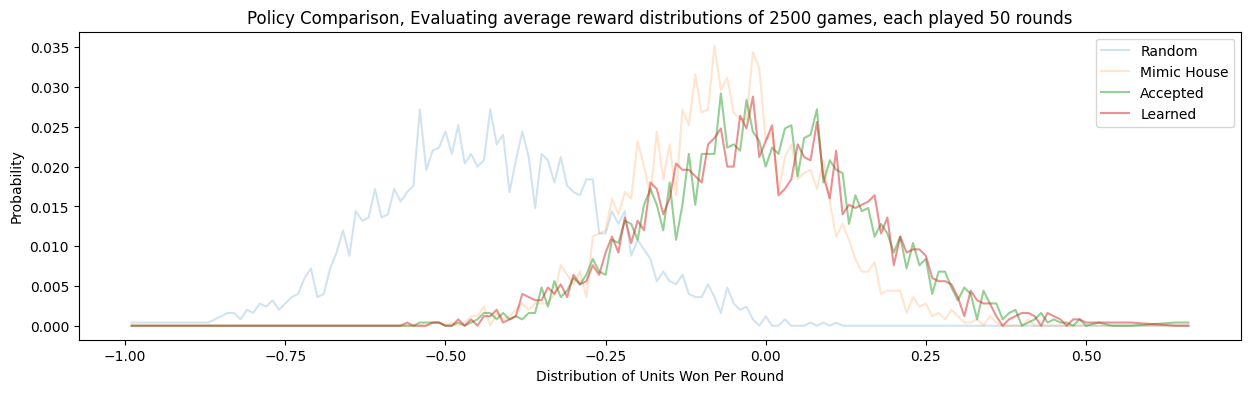

In [14]:
plt.figure(figsize=(15,4))
plt.title(f"Policy Comparison, Evaluating average reward distributions of {n_games} games, each played {n_rounds} rounds")

plot_bar(
    datas=[random_rewards, meh_rewards, accepted_rewards, learned_rewards],
    alphas=[0.2, 0.2, 0.5, 0.5],
    labels=["Random", "Mimic House", "Accepted", "Learned"]
)

plt.xlabel("Distribution of Units Won Per Round")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [15]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{np.mean(random_rewards):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{np.mean(meh_rewards):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{np.mean(accepted_rewards):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{np.mean(learned_rewards):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4276 units net per round

Mimicing the House:
	-0.0653 units net per round

Following Accepted Policy:
	-0.0080 units net per round

Following Learned Policy:
	-0.0116 units net per round



### While sampling helped in training Q values, it"s clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn"t even take card count into account**

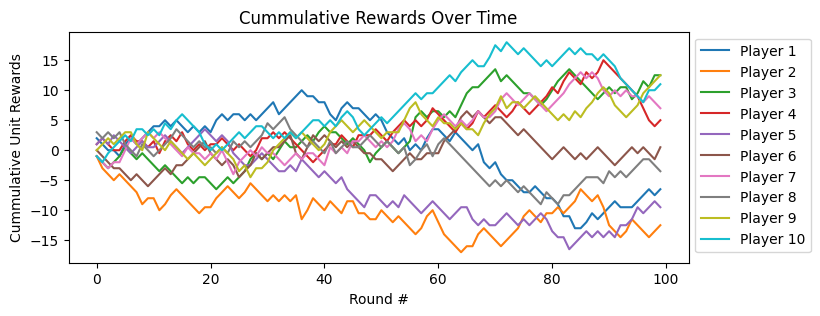

In [16]:
rewards = await play_n_games(
    q=Qlearned,
    wagers=[1],
    n_rounds=100,
    n_games=10,
    game_hyperparams=game_hyperparams
)

plt.figure(figsize=(8,3))
for i,round in enumerate(np.cumsum(rewards, axis=2)[:,0,:]):
    plt.plot(round,label="Player {}".format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Cummulative Rewards Over Time")
plt.xlabel("Round #")
plt.ylabel("Cummulative Unit Rewards")
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [18]:
game = Game(**game_hyperparams)

play_round(
    game=game,
    q=Qlearned,
    wagers=[1],
    verbose=True
)

Player Cards + Moves:
[Cards(cards=[Card(suit=<SuitEnum.spades: 's'>, card='J'), Card(suit=<SuitEnum.spades: 's'>, card=7)])] stay

House Cards
[Card(suit=<SuitEnum.spades: 's'>, card=6), Card(suit=<SuitEnum.spades: 's'>, card=8), Card(suit=<SuitEnum.diamonds: 'd'>, card=9)]

Result:


([['win']], [[1]])

## Evaluation

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, what the "value" is of being in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, what the "quality" is of being in state $s$ and taking action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$.

In our case, $\pi(s,a)$ will equal 1 if the action is equal to $max(Q(s,a))$, and 0 otherwise, which leads to the following:

$$V_s = max(Q(s,a))$$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic. We can assume that selecting an action will always lead to that action being taken, without error.

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [19]:
value_det = generate_mesh(Qlearned)

fill = generate_grid(Qlearned)
fill_accepted = generate_grid(init_q(mode="accepted"))

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don"t learn transition probabilities in this model-free method, so we always take the best action in our environment

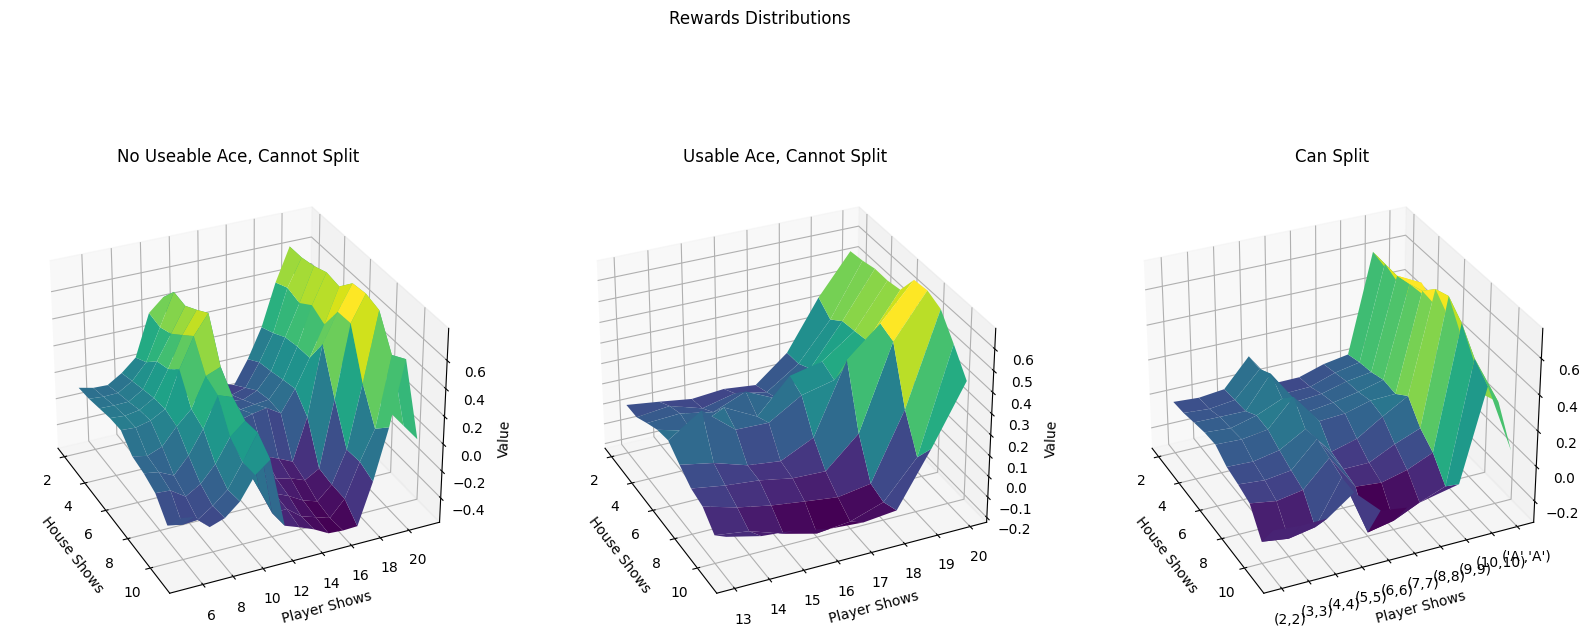

In [20]:
fig = plt.figure(figsize=(20,8))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(ax, value_det[0][5:,2:], [range(2,12),range(5,22)], ticks=None)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(ax, value_det[1][13:21,2:], [range(2,12),range(13,21)], ticks=None)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(ax, value_det[2][2:12,2:], [range(2,12),range(2,12)], ticks=ticks)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

In [21]:
colorMap = {
    "St":"yellow",
    "Hi":"white",
    "Do":"green",
    "Su":"grey",
    "Sp":"blue",
    "Do/Hi": "green",
    "Do/St": "green"
}

In [22]:
print("Accepted with No Useable Ace")
noAce = pd.DataFrame(fill_accepted[0])
noAce = noAce.iloc[5:][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
noAce

Accepted with No Useable Ace


,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
10,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi
11,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi
12,Hi,Hi,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [23]:
print("Learned with No Useable Ace")
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
noAce

Learned with No Useable Ace


,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
10,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi
11,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi
12,Hi,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,Hi,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [24]:
print("Accepted with Useable Ace")
usableAce = pd.DataFrame(fill_accepted[1])
usableAce = usableAce.iloc[13:21][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
usableAce

Accepted with Useable Ace


,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
17,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
18,Do/St,Do/St,Do/St,Do/St,Do/St,St,St,Hi,Hi,Hi
19,St,St,St,St,Do/St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [25]:
print("Learned with Useable Ace")
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)]\
    .style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
usableAce

Learned with Useable Ace


,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
14,Hi,Do/Hi,Do/Hi,Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
16,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
17,Hi,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi
18,St,St,Do/St,Do/St,Do/St,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [26]:
print("Accepted with Ability to Split")
canSplit = pd.DataFrame(fill_accepted[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ("A","A") for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
canSplit

Accepted with Ability to Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(4, 4)",Hi,Hi,Hi,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",Sp,Sp,Sp,Sp,Sp,St,Sp,Sp,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


In [27]:
print("Learned with Ability to Split")
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ("A","A") for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: "background-color: %s; color: black" % colorMap[x])
canSplit

Learned with Ability to Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(4, 4)",Hi,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Hi,Do,Do,Do,Do
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Sp,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Sp
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",Sp,Sp,St,Sp,Sp,St,Sp,Sp,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


## I"m curious about frequency of busting as the house, on certain card totals

In [38]:
game = Game(**game_hyperparams)

results, busts, player_results = assess_static_outcomes(
    game=game,
    q=Qlearned,
    n_rounds=100_000
)

In [39]:
print("Average Player Rewards Given Card Total at Draw")
for i in range(4, 22) :
    print(f"Card Total: {i}")
    if player_results["soft"][i]["n"] > 0 :
        print(f"\tSoft: {player_results['soft'][i]['rewards']/player_results['soft'][i]['n']}")
    else :
        print("\tSoft: NONE")
    if player_results["hard"][i]["n"] > 0 :
        print(f"\tHard: {player_results['hard'][i]['rewards']/player_results['hard'][i]['n']}")
    else :
        print("\tHard: NONE")

Average Player Rewards Given Card Total at Draw
Card Total: 4
	Soft: NONE
	Hard: -0.20512820512820512
Card Total: 5
	Soft: NONE
	Hard: -0.21018062397372742
Card Total: 6
	Soft: NONE
	Hard: -0.304884896125772
Card Total: 7
	Soft: NONE
	Hard: -0.22019464720194648
Card Total: 8
	Soft: NONE
	Hard: -0.1291199456337071
Card Total: 9
	Soft: NONE
	Hard: -0.03516732841747022
Card Total: 10
	Soft: NONE
	Hard: 0.21954813359528488
Card Total: 11
	Soft: NONE
	Hard: 0.30088870080406266
Card Total: 12
	Soft: 0.4271186440677966
	Hard: -0.3144075403949731
Card Total: 13
	Soft: -0.007751937984496124
	Hard: -0.3417540514775977
Card Total: 14
	Soft: -0.03273322422258593
	Hard: -0.38686790505675955
Card Total: 15
	Soft: -0.05407725321888412
	Hard: -0.4003345413994982
Card Total: 16
	Soft: -0.0724755700325733
	Hard: -0.36316511663363316
Card Total: 17
	Soft: -0.0695142378559464
	Hard: -0.297079556898288
Card Total: 18
	Soft: 0.07771135781383433
	Hard: -0.02001906577693041
Card Total: 19
	Soft: 0.27515583259

In [40]:
print("Probability of House Having a Value on Bust")
for i in range(22,27) :
    print(f"Total {i}: {100*busts[i]/sum(busts.values())}%")

Probability of House Having a Value on Bust
Total 22: 25.5291652113168%
Total 23: 23.136570031435557%
Total 24: 20.069856793573177%
Total 25: 17.034579112818722%
Total 26: 14.229828850855746%


In [41]:
print("Probability of House Result")
out = []
for i in range(2,12) :
    inter = {}
    inter["Card Show"] = i
    for j in range(17,22) :
        inter[f"% {j}"] = 100*results[i][str(j)]/results[i]["n"]
    inter["% Bust"] = 100*results[i]["bust"]/results[i]["n"]
    out.append(inter)
              
pd.DataFrame(out)

Probability of House Result


,Card Show,% 17,% 18,% 19,% 20,% 21,% Bust
0,2,13.206333,13.322178,13.592483,12.742953,12.060754,35.075299
1,3,12.560135,13.353270,12.820179,11.740996,11.545963,37.979457
2,4,12.208628,12.543464,12.620734,11.654862,11.281391,39.690921
3,5,11.483567,12.059709,11.954956,11.169307,11.208590,42.123871
4,6,11.647727,11.157025,11.027893,11.286157,10.162707,44.718492
5,7,37.354746,13.866040,7.298603,8.121165,7.507508,25.851939
6,8,12.708768,36.351775,13.100209,6.132568,6.484864,25.221816
7,9,12.053049,12.313093,35.261995,11.714992,5.981017,22.675855
8,10,11.229268,11.157724,11.193496,34.198374,11.004878,21.216260
9,11,5.910878,13.997379,14.574050,14.023591,37.850590,13.643512


## Bankroll

Bankroll is an important component of blackjack. 
Given the randomness of blackjack, even if playing optimally, there is a likelihood that a player will run out of money in the short term.

I'm curious how a player's bankroll impacts their chance of success compared to the minimum wager allowed during a game. If working with a low bankroll, there is a decent likelihood that players will only "survive" a certain number of hands.

In [45]:
wager = 1
bankroll_inits = [5, 10, 25, 50]

n_games = 500
n_rounds = 500

rounds_lasted_nest, rounds_profitable_nest, profits_nest = await play_games_bankrolls(
    q=Qlearned,
    wager=1,
    max_rounds=n_rounds,
    n_games=n_games,
    bankrolls=bankroll_inits,
    game_hyperparams=game_hyperparams
)



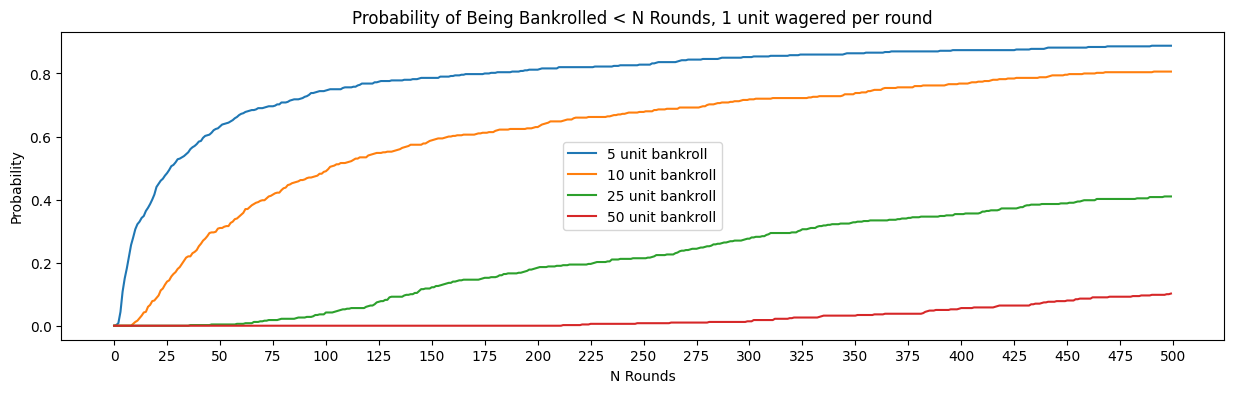

In [46]:
plt.figure(figsize=(15,4))
for i, bankroll in enumerate(bankroll_inits):
    x = np.arange(0,n_rounds)
    y = [rounds_lasted_nest[i].count(val) for val in x]
    plt.plot(x, np.cumsum(y)/len(y), label=f"{bankroll} unit bankroll")

plt.xticks(list(np.arange(0,n_rounds+1))[::25])
plt.title("Probability of Being Bankrolled < N Rounds, 1 unit wagered per round")
plt.xlabel("N Rounds")
plt.ylabel("Probability")
plt.legend()
plt.show()

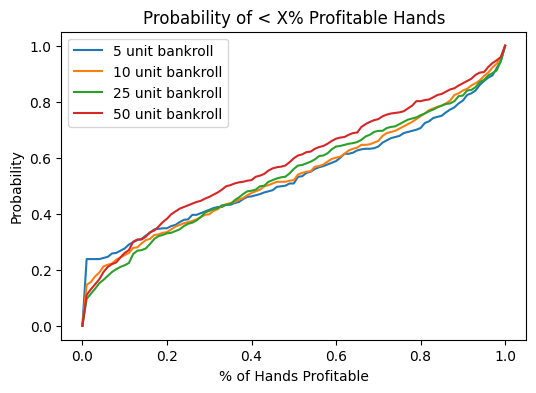

In [47]:
plt.figure(figsize=(6,4))
for i, bankroll in enumerate(bankroll_inits):
    x = np.arange(-.01,1.01,0.01)
    prob = np.array(rounds_profitable_nest[i]) / np.array(rounds_lasted_nest[i])
    c, _ = np.histogram(prob, x)
    plt.plot(x[1:], np.cumsum(c) / c.sum(), label=f"{bankroll} unit bankroll")

plt.title("Probability of < X% Profitable Hands")
plt.xlabel("% of Hands Profitable")
plt.ylabel("Probability")
plt.legend()
plt.show()

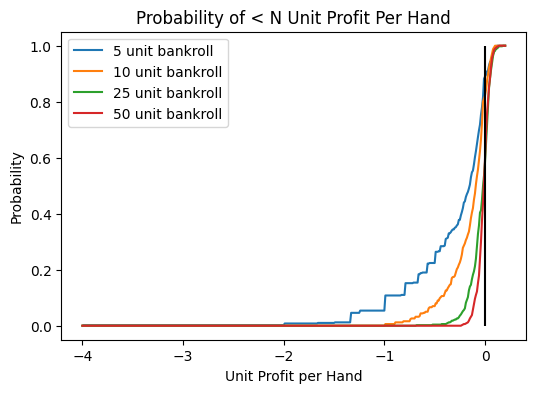

In [48]:
plt.figure(figsize=(6,4))

min_val = np.min(np.array(profits_nest) / np.array(rounds_lasted_nest))
max_val = np.max(np.array(profits_nest) / np.array(rounds_lasted_nest))

for i, bankroll in enumerate(bankroll_inits):
    x = np.arange(min_val-0.01, max_val+0.01, 0.01)
    prob = np.array(profits_nest[i]) / np.array(rounds_lasted_nest[i])
    c, _ = np.histogram(prob, x)
    plt.plot(x[1:], np.cumsum(c) / c.sum(), label=f"{bankroll} unit bankroll")

plt.vlines(0, 1, 0, "black")
plt.title("Probability of < N Unit Profit Per Hand")
plt.xlabel("Unit Profit per Hand")
plt.ylabel("Probability")
plt.legend()
plt.show()

There are 3 stories told here by the idea behind bankrolling.
- As our bankroll increases with respect to the minimum wager, our probability of going broke decreases
- With different bankrolls, we don't observe great differences between the percent of profitable hands during that gameplay. This holds except for very low percent of profitable hands, where we see a large initial spike for 0% profitable hands for small bankrolls
- Most interestingly, the impacts of bankroll is shown in our unit profit per hand. With identical policies (and knowing from above that our expected value per hand is roughly zero), while even having some constraint on our bankroll, we are not able to achieve this expected value. The effect becomes more obvious as we drop our bankroll. This is because while rewards can drop during various gameplays due to randomness, since we go broke faster with smaller bankrolls, on average, our agent has less of a chance to recover to the mean expected value.

So, while the expected value of the Q learning policy is roughly zero, in practice, the agent can run out of money and becomes less profitable in the long run if a smaller bankroll is in play.